# Предсказание выбросов ГТД

## Техническое задание:

Прогнозирование выбросов CO и NOx по характеристикам ГТД

# Импорт библиотек

Стандартные библиотеки

In [47]:
import os
import sys
import pickle
from colorama import Fore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score,mean_squared_error

import tensorflow as tf
import torch

In [2]:
for lib in (pd, np, tf, torch):
    print(f'{lib.__name__}: {lib.__version__}')

pandas: 2.2.2
numpy: 1.26.4
tensorflow: 2.16.1
torch: 2.3.0+cpu


Частные библиотеки

In [3]:
sys.path.append('D:/Programming/Python/scripts')

In [4]:
from pandas_tools import DataFrame

## Импорт и визуализация исходных данных

In [5]:
for root, dirs, files in os.walk('datas'):
    if files:
        print('root: ', Fore.RED + root + Fore.RESET)
        print('directories: ', Fore.YELLOW + ', '.join(dirs) + Fore.RESET)
        print('files: ' + Fore.GREEN + ', '.join(files) + Fore.RESET)
        print()

root:  datas\external
directories:  
files: gte_emissions.csv



Данные содержат 36733 экземпляров 11 измерений датчиков, агрегированных за один час (посредством среднего значения или суммы) газовой турбины. 
Набор данных включает параметры газовой турбины такие как температура на входе в турбину и давление нагнетания компрессора, а также параметры окружающей среды.

Пояснения к сенсорным измерениям и их краткая статистика приведены ниже.

`сокр.` [Единица измерения] = Переменная 

- `AT` [K] = Температура окружающей среды
- `AP` [кПа] = Давление окружающей среды 
- `AH` [%] = Влажность окружающей среды  

- `AFDP` [кПа] = Потеря давления в воздушном фильтре 
- `CDP` [кПА] = Давление после компрессора
- `GTEP` [кПа] = Давление выхлопа газовой турбины 

- `TIT` [K] = Температура перед турбину 
- `TAT` [K] = Температура после турбины  

- `TEY` [МВт*ч] = Энергетический выход турбины 
- `CO` [мг/м^3] = Оксид углерода 
- `NOx` [мг/м^3] = Оксиды азота 

In [6]:
df = pd.read_csv('datas/external/gte_emissions.csv')
df = DataFrame(df)

In [7]:
df

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,277.7378,101.870,83.675,3.5758,239.79,1359.35,822.98,134.67,1189.8,0.32663,81.952
1,277.4432,101.830,84.235,3.5709,239.51,1359.25,823.20,134.67,1189.2,0.44784,82.377
2,277.0545,101.840,84.858,3.5828,239.90,1359.65,823.34,135.10,1204.2,0.45144,83.776
3,276.8936,101.830,85.434,3.5808,239.11,1359.65,823.32,135.03,1199.0,0.23107,82.505
4,276.9016,101.780,85.182,3.5781,239.17,1359.05,823.15,134.67,1191.0,0.26747,82.028
...,...,...,...,...,...,...,...,...,...,...,...
36728,276.7768,102.850,93.200,3.1661,190.87,1310.15,814.74,109.08,1041.1,10.99300,89.172
36729,277.3174,102.859,94.036,3.1923,190.16,1310.75,815.43,108.79,1034.4,11.14400,88.849
36730,278.6320,102.850,95.219,3.3128,188.57,1311.15,816.63,107.81,1046.2,11.41400,96.147
36731,279.0337,102.870,94.200,3.9831,235.63,1350.05,823.26,131.41,1177.1,3.31340,64.738


# Data Engeneering

### Предварительная обработка

Переименование

- i = inlet
- o = outlet

In [8]:
df.rename(columns={'AT': 'T_atm', 'AP': 'P_atm', 'AH': 'H_atm',
                   'AFDP': 'dP_inlet',
                   'TIT': 'T_turbine_i', 'TAT': 'T_turbine_o',
                   'CDP': 'P_compressor_o',
                   'GTEP': 'P_outlet_o',
                   'TEY': 'A',
                   'NOX': 'NOx'},
          inplace=True)

In [9]:
df.columns

Index(['T_atm', 'P_atm', 'H_atm', 'dP_inlet', 'P_outlet_o', 'T_turbine_i',
       'T_turbine_o', 'A', 'P_compressor_o', 'CO', 'NOx'],
      dtype='object')

### Обрботка типов данных

In [10]:
df.info(memory_usage='deep')

<class 'pandas_tools.DataFrame'>
RangeIndex: 36733 entries, 0 to 36732
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   T_atm           36733 non-null  float64
 1   P_atm           36733 non-null  float64
 2   H_atm           36733 non-null  float64
 3   dP_inlet        36733 non-null  float64
 4   P_outlet_o      36733 non-null  float64
 5   T_turbine_i     36733 non-null  float64
 6   T_turbine_o     36733 non-null  float64
 7   A               36733 non-null  float64
 8   P_compressor_o  36733 non-null  float64
 9   CO              36733 non-null  float64
 10  NOx             36733 non-null  float64
dtypes: float64(11)
memory usage: 3.1 MB


### Обработка локальных пустот

In [11]:
df.isna().sum()

T_atm             0
P_atm             0
H_atm             0
dP_inlet          0
P_outlet_o        0
T_turbine_i       0
T_turbine_o       0
A                 0
P_compressor_o    0
CO                0
NOx               0
dtype: int64

In [12]:
df[df.duplicated()].shape

(7, 11)

In [13]:
df.drop_duplicates(ignore_index=True, inplace=True)

In [14]:
df[df.duplicated()].shape

(0, 11)

### Выделение признаков

Проверка на отрицательную температуру

In [15]:
df[df['T_atm'] <= 273.15]

,T_atm,P_atm,H_atm,dP_inlet,P_outlet_o,T_turbine_i,T_turbine_o,A,P_compressor_o,CO,NOx
29360,272.93402,102.670,51.978,2.5301,194.38,1323.55,819.86,115.46,1076.7,7.0983,116.960
29374,273.06790,102.370,64.949,2.8720,238.98,1348.55,823.36,133.77,1173.7,3.7902,85.485
29375,272.63219,102.330,69.287,2.8670,236.92,1348.25,823.49,133.77,1173.4,3.3021,85.342
29376,272.15140,102.280,70.710,2.9023,234.62,1348.25,823.45,133.03,1171.0,1.8773,84.164
29377,272.06590,102.230,70.733,2.8280,226.04,1345.05,823.46,130.41,1152.6,1.7751,83.696
...,...,...,...,...,...,...,...,...,...,...,...
29511,267.26530,103.359,66.920,4.2815,362.18,1373.15,793.39,176.55,1489.1,1.2721,56.124
29512,267.10790,103.330,68.008,4.4238,375.05,1373.05,789.19,179.50,1515.9,1.5776,55.572
29513,267.52820,103.320,66.772,4.3915,371.05,1373.05,790.87,177.91,1502.9,1.6697,56.386
29514,268.58360,103.280,69.383,4.1850,350.72,1373.25,797.70,173.05,1462.6,1.4528,59.496


In [16]:
df['sigma_inlet'] = 1 - df['dP_inlet'] / df['P_atm']

df['P_compressor_i'] = df['P_atm'] - df['dP_inlet']

df['theta_turbine'] = df['T_turbine_i'] / df['T_turbine_o']

df['pi_compressor'] = df['P_compressor_o'] / (df['P_atm'] - df['dP_inlet'])
df['pi_turbine'] = df['P_compressor_o'] / df['P_outlet_o']
df['pi_outlet'] = df['P_outlet_o'] / df['P_atm']

In [17]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,36716,36717,36718,36719,36720,36721,36722,36723,36724,36725
T_atm,277.737800,277.443200,277.054500,276.893600,276.901600,277.035800,276.819700,276.739200,276.860800,277.978100,...,278.938400,277.502800,276.917500,276.571800,276.527600,276.776800,277.317400,278.632000,279.033700,279.189200
P_atm,101.870000,101.830000,101.840000,101.830000,101.780000,101.770000,101.800000,101.820000,101.850000,101.850000,...,102.920000,102.920000,102.900000,102.870000,102.850000,102.850000,102.859000,102.850000,102.870000,102.880000
H_atm,83.675000,84.235000,84.858000,85.434000,85.182000,83.946000,84.114000,83.867000,84.948000,85.346000,...,85.360000,87.147000,89.609000,91.003000,92.703000,93.200000,94.036000,95.219000,94.200000,94.547000
dP_inlet,3.575800,3.570900,3.582800,3.580800,3.578100,3.582400,3.580400,3.577700,3.602700,3.515800,...,4.857000,4.996000,5.073300,3.691100,3.312800,3.166100,3.192300,3.312800,3.983100,3.875200
P_outlet_o,239.790000,239.510000,239.900000,239.110000,239.170000,239.030000,238.890000,238.760000,239.570000,234.220000,...,336.440000,340.940000,334.020000,228.590000,202.480000,190.870000,190.160000,188.570000,235.630000,225.240000
T_turbine_i,1359.350000,1359.250000,1359.650000,1359.650000,1359.050000,1359.150000,1359.050000,1359.150000,1359.450000,1356.250000,...,1373.150000,1373.150000,1372.950000,1346.650000,1330.750000,1310.150000,1310.750000,1311.150000,1350.050000,1341.050000
T_turbine_o,822.980000,823.200000,823.340000,823.320000,823.150000,823.130000,823.190000,823.030000,823.130000,822.950000,...,802.340000,800.880000,802.970000,822.930000,823.450000,814.740000,815.430000,816.630000,823.260000,821.380000
A,134.670000,134.670000,135.100000,135.030000,134.670000,134.670000,134.680000,134.660000,134.650000,132.670000,...,165.410000,167.040000,165.780000,129.860000,117.460000,109.080000,108.790000,107.810000,131.410000,125.410000
P_compressor_o,1189.800000,1189.200000,1204.200000,1199.000000,1191.000000,1186.800000,1187.700000,1189.300000,1187.000000,1169.400000,...,1432.200000,1437.800000,1420.500000,1154.900000,1078.300000,1041.100000,1034.400000,1046.200000,1177.100000,1146.200000
CO,0.326630,0.447840,0.451440,0.231070,0.267470,0.234730,0.444120,0.799960,0.689960,1.028100,...,1.795500,1.761800,1.935600,3.673800,5.348800,10.993000,11.144000,11.414000,3.313400,11.981000


### Обработка выбросов

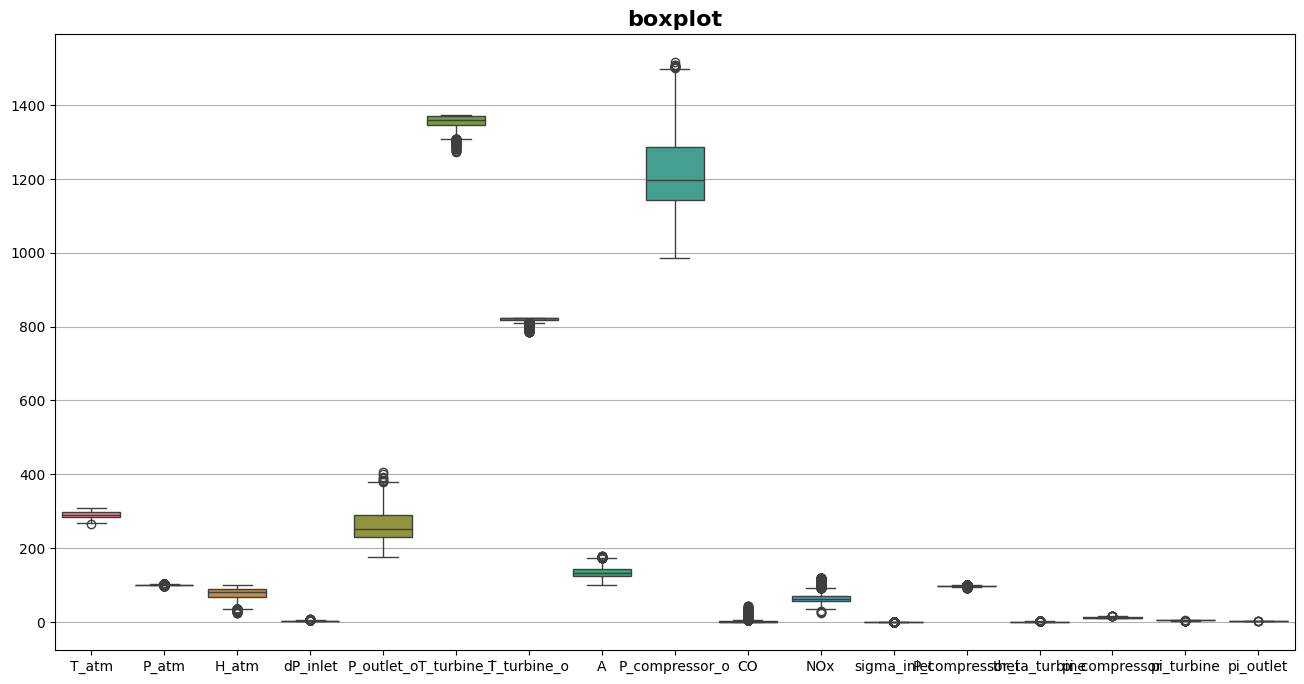

In [18]:
df.boxplot(figsize=(16, 8), widths=1);

## Статистика

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
T_atm,36726.0,290.861451,7.447561,266.915200,284.929250,290.948000,296.814000,310.253000
P_atm,36726.0,101.307141,0.646291,98.585000,100.880000,101.260000,101.700000,103.659000
H_atm,36726.0,77.864274,14.461250,24.085000,68.182500,80.465500,89.373750,100.200000
dP_inlet,36726.0,3.925410,0.773939,2.087400,3.355525,3.937450,4.376800,7.610600
P_outlet_o,36726.0,255.635374,41.961568,176.980000,231.272500,251.045000,290.590000,407.160000
T_turbine_i,36726.0,1354.577166,17.537244,1273.950000,1344.950000,1359.050000,1370.150000,1374.050000
T_turbine_o,36726.0,819.308062,6.842901,784.190000,817.870000,823.030000,823.190000,823.760000
A,36726.0,133.506079,15.619558,100.020000,124.450000,133.730000,144.080000,179.500000
P_compressor_o,36726.0,1206.046986,108.886068,985.180000,1143.400000,1196.500000,1285.375000,1515.900000
CO,36726.0,2.372627,2.262856,0.000388,1.182325,1.713700,2.843350,44.103000


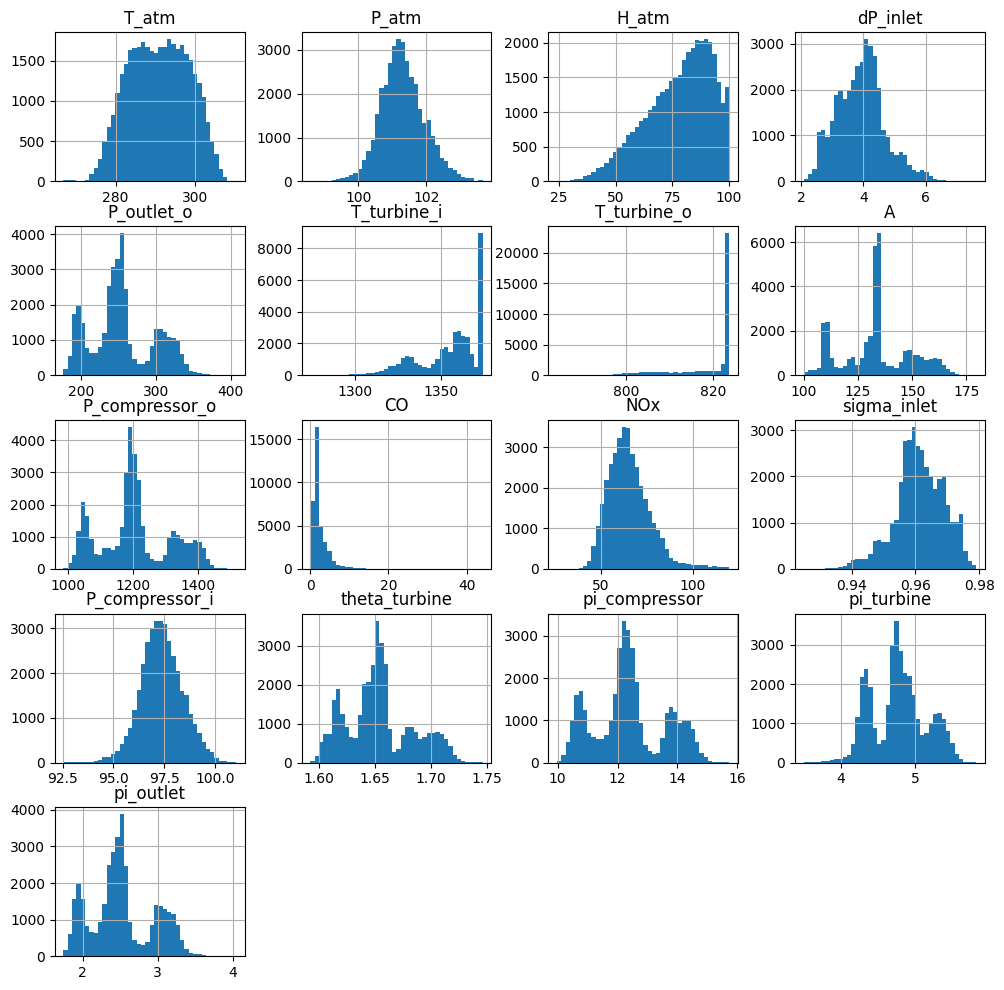

In [20]:
df.histplot()

### Корреляционный анализ

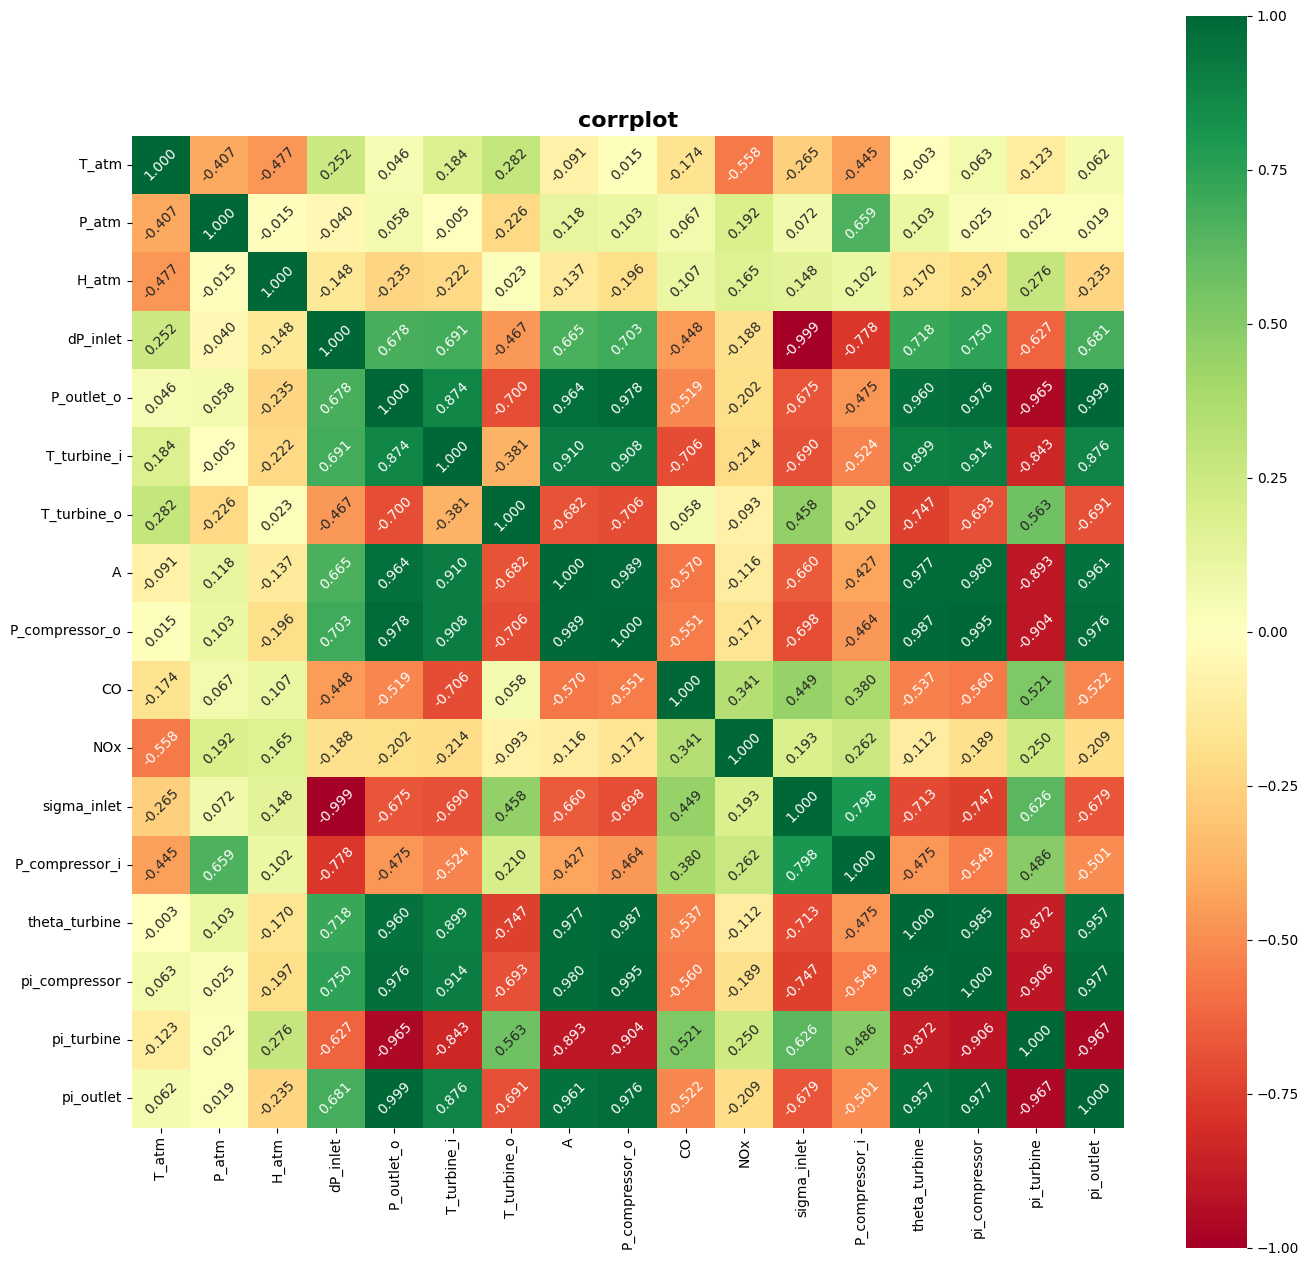

In [21]:
df.corrplot(figsize=(16, 16), fmt=3)

In [22]:
df.drop(['A', 
         'dP_inlet', 
         'P_compressor_i', 'P_compressor_o', 
         'theta_turbine', 'T_turbine_i', 'pi_turbine', 
         'pi_outlet', 'P_outlet_o'], 
         axis=1, inplace=True)

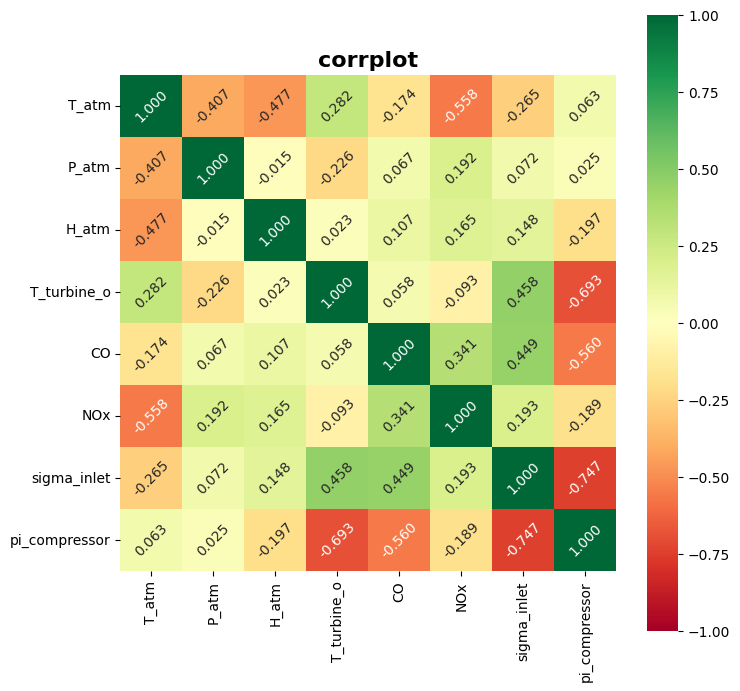

In [23]:
df.corrplot(figsize=(8, 8), fmt=3)

### Feature importance

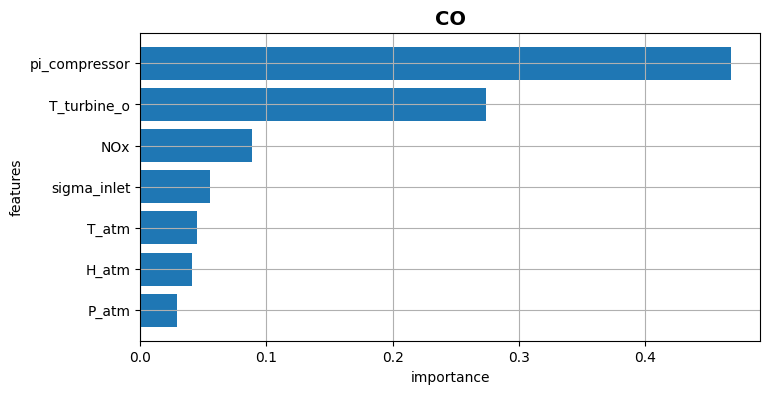

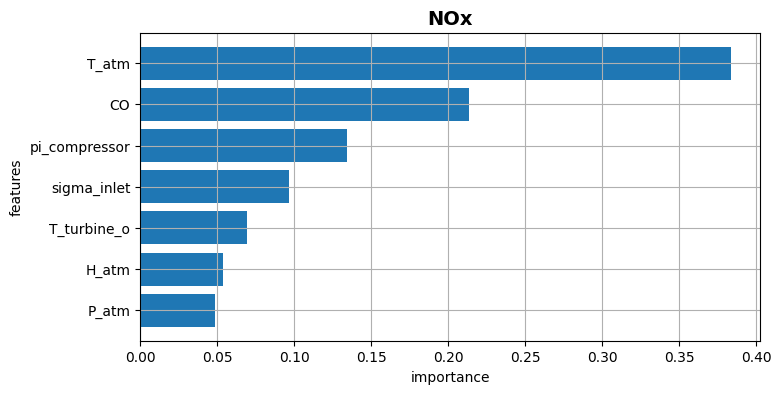

In [24]:
for target in ('CO', 'NOx'):
    df.random_forest_importance_features_plot(target=target, figsize=(8, 4))

## Preprocessing

Параметры разделения

In [25]:
test_size = 0.25
shuffle = True
random_state = 0

In [26]:
df_train, df_test = train_test_split(df,
                                     test_size=test_size,                                                    
                                     shuffle=shuffle,                                                    
                                     random_state=random_state)

In [27]:
print(f'train shape: {df_train.shape}')
print(f'test shape: {df_test.shape}')

train shape: (27544, 8)
test shape: (9182, 8)


## ML

In [28]:
MODELS = (LinearRegression, KNeighborsRegressor, RandomForestRegressor)

In [50]:
%%time

result_CO, result_NOx = dict(), dict()
for target, result in zip(('CO', 'NOx'), (result_CO, result_NOx)):
    print(target)
    for Model in MODELS:
        model = Model()
        model.fit(df_train.drop(['CO', 'NOx'], axis=1), df_train[target])
        y_pred = model.predict(df_test.drop(['CO', 'NOx'], axis=1))
        result[Model.__name__] = {'model': model, 
        'mae': mean_absolute_error(df_test[target], y_pred), 
        'mse': mean_squared_error(df_test[target], y_pred),
        'r2': r2_score(df_test[target], y_pred)}
    display(pd.DataFrame(result).T)

CO


,model,mae,mse,r2
LinearRegression,LinearRegression(),0.930732,2.539062,0.534422
KNeighborsRegressor,KNeighborsRegressor(),0.767989,2.159358,0.604047
RandomForestRegressor,"(DecisionTreeRegressor(max_features=1.0, rando...",0.516463,1.237027,0.773171
ExtraTreesRegressor,"(ExtraTreeRegressor(random_state=166850362), E...",0.517383,1.251569,0.770505


NOx


,model,mae,mse,r2
LinearRegression,LinearRegression(),7.084725,85.514397,0.392017
KNeighborsRegressor,KNeighborsRegressor(),5.279859,52.603984,0.626001
RandomForestRegressor,"(DecisionTreeRegressor(max_features=1.0, rando...",3.185146,22.97593,0.836648
ExtraTreesRegressor,"(ExtraTreeRegressor(random_state=1143609336), ...",3.022999,20.596961,0.853561


CPU times: total: 46.2 s
Wall time: 45.8 s


In [51]:
print(result_CO)
print(result_NOx)

{'LinearRegression': {'model': LinearRegression(), 'mae': 0.9307323882586118, 'mse': 2.539062484190048, 'r2': 0.5344216810304472}, 'KNeighborsRegressor': {'model': KNeighborsRegressor(), 'mae': 0.7679894254759312, 'mse': 2.159358447699261, 'r2': 0.6040465792423269}, 'RandomForestRegressor': {'model': RandomForestRegressor(), 'mae': 0.5164630834719125, 'mse': 1.2370271753755822, 'r2': 0.7731709887341593}, 'ExtraTreesRegressor': {'model': ExtraTreesRegressor(), 'mae': 0.5173829696408953, 'mse': 1.2515689741992462, 'r2': 0.7705045138863478}}
{'LinearRegression': {'model': LinearRegression(), 'mae': 7.084725371080864, 'mse': 85.51439683684492, 'r2': 0.3920169907807226}, 'KNeighborsRegressor': {'model': KNeighborsRegressor(), 'mae': 5.279859464169026, 'mse': 52.60398431645393, 'r2': 0.6260006517655591}, 'RandomForestRegressor': {'model': RandomForestRegressor(), 'mae': 3.185146241559573, 'mse': 22.97593025894684, 'r2': 0.8366476788101714}, 'ExtraTreesRegressor': {'model': ExtraTreesRegresso

In [52]:
with open('models/gte_emission_CO.pkl', 'wb') as file:
    pickle.dump(result_CO['ExtraTreesRegressor']['model'], file)

In [53]:
with open('models/gte_emission_NOx.pkl', 'wb') as file:
    pickle.dump(result_NOx['ExtraTreesRegressor']['model'], file)

## DL

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input())
model.add(tf.keras.layers.Dense(10, input_dim=10, kernel_initializer='uniform', activation='relu'))
model.add(tf.keras.layers.Dense(4, kernel_initializer='uniform',activation='relu'))
model.add(tf.keras.layers.Dense(4, kernel_initializer='uniform',activation='relu'))
model.add(tf.keras.layers.Dense(1, kernel_initializer='uniform',activation='sigmoid'))

c:\Python\Python 3.11.9\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179 (716.00 B)

 Trainable params: 179 (716.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [ ]:
history=model.fit(X,y,validation_split=0.20,epochs=100,batch_size=10)

Epoch 1/100


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 10, but received input with shape (10, 9)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(10, 9), dtype=float32)
  • training=True
  • mask=None

In [ ]:
scores = model.evaluate(X,Y)
print("%s: %0.2f%%" %(model.metrics_names[1],scores[1]*100))